#**SMS Spam Detection**
## [Huggingface](https://huggingface.co/)

dataset: https://huggingface.co/datasets/ucirvine/sms_spam

In [69]:
import pandas as pd

dataset = pd.read_parquet("hf://datasets/ucirvine/sms_spam/plain_text/train-00000-of-00001.parquet")

dataset.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


# **Visualization**

### Spam vs legitimate messages

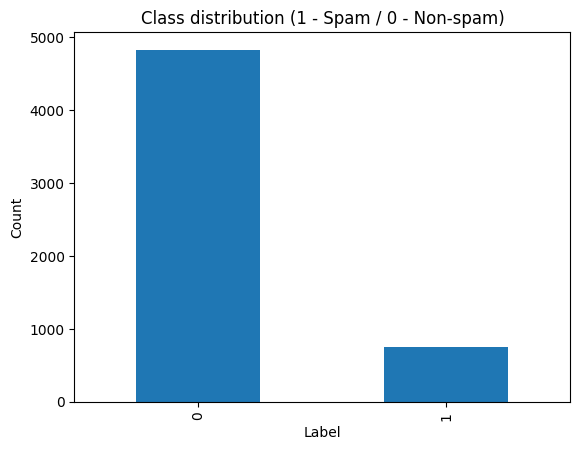

In [70]:
import matplotlib.pyplot as plt

label_counts = dataset["label"].value_counts()

label_counts.plot(kind="bar")
plt.title("Class distribution (1 - Spam / 0 - Non-spam)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Message length distribution

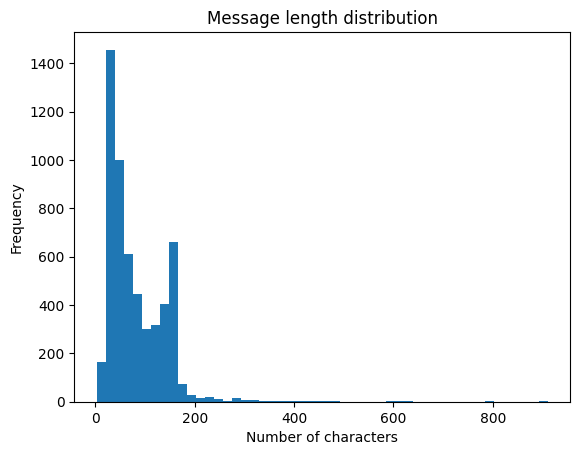

In [71]:
dataset["message_length"] = dataset["sms"].str.len()

plt.hist(dataset["message_length"], bins=50)
plt.title("Message length distribution")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()

# **Text Cleaning**

In [72]:
import re

def clean_text(text: str) -> str:
    # lowercase
    text = text.lower()

    # remove urls
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # keep letters/numbers and whitespace only (remove punctuation/special chars)
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

dataset["sms_clean"] = dataset["sms"].astype(str).apply(clean_text)

# quick sanity check
dataset[["sms", "sms_clean", "label"]].sample(5)

,sms,sms_clean,label
4083,No no. I will check all rooms befor activities\n,no no i will check all rooms befor activities,0
2149,I will once i get home\n,i will once i get home,0
1689,Nan sonathaya soladha. Why boss?\n,nan sonathaya soladha why boss,0
1072,URGENT! We are trying to contact U. Todays dra...,urgent we are trying to contact u todays draw ...,1
1059,Tell me they're female :V how're you throwing ...,tell me they re female v how re you throwing i...,0


# **UnitTest**

In [73]:
import unittest

class TestCleanText(unittest.TestCase):

    def test_lowercase(self):
        self.assertEqual(clean_text("HeLLo WoRLD"), "hello world")

    def test_remove_urls(self):
        self.assertEqual(clean_text("visit http://example.com now"), "visit now")
        self.assertEqual(clean_text("go to www.example.com please"), "go to please")

    def test_remove_punctuation_special_chars(self):
        self.assertEqual(clean_text("Hello!!! $$$"), "hello")
        self.assertEqual(clean_text("win @@@ now!!!"), "win now")

    def test_whitespace_normalization(self):
        self.assertEqual(clean_text("  hello   world  "), "hello world")
        self.assertEqual(clean_text("hello\tworld\n"), "hello world")
        self.assertEqual(clean_text("  hello \t world \n "), "hello world")

    def test_numbers_kept(self):
        self.assertEqual(clean_text("call 123 now!!!"), "call 123 now")

    def test_empty_string(self):
        self.assertEqual(clean_text(""), "")

    def test_only_whitespace(self):
        self.assertEqual(clean_text("   \t \n "), "")

    def test_only_punctuation(self):
        self.assertEqual(clean_text("!!!@@@"), "")

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

........
----------------------------------------------------------------------
Ran 8 tests in 0.011s

OK


# **Tokenization**

In [74]:
def tokenize(text: str) -> list[str]:
    return text.split()

dataset["tokens"] = dataset["sms_clean"].astype(str).apply(tokenize)

dataset[["sms_clean", "tokens", "label"]].sample(5)

dataset["token_count"] = dataset["tokens"].apply(len)
dataset[["token_count"]].describe()

,token_count
count,5574.000000
mean,16.108181
std,11.727005
min,0.000000
25%,8.000000
50%,13.000000
75%,24.000000
max,190.000000


# **Vectorization**

In [75]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X_text = dataset["sms_clean"].astype(str)
y = dataset["label"].astype(int)

# 1) CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 1))
X_count = count_vectorizer.fit_transform(X_text)

# 2) TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

print("X_count shape:", X_count.shape)
print("X_tfidf shape:", X_tfidf.shape)

X_count shape: (5574, 8651)
X_tfidf shape: (5574, 8651)


# **Validation, Test, Train**

In [76]:
from sklearn.model_selection import train_test_split

# 1)train+val vs test (80% / 20%)
X_count_trainval, X_count_test, y_trainval, y_test = train_test_split(
    X_count,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_tfidf_trainval, X_tfidf_test, _, _ = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2)train vs validation (80% / 20% train+val)
X_count_train, X_count_val, y_train, y_val = train_test_split(
    X_count_trainval,
    y_trainval,
    test_size=0.2,
    random_state=42,
    stratify=y_trainval
)

X_tfidf_train, X_tfidf_val, _, _ = train_test_split(
    X_tfidf_trainval,
    y_trainval,
    test_size=0.2,
    random_state=42,
    stratify=y_trainval
)

print("COUNT VECTORIZER SPLITS")
print("Train:", X_count_train.shape)
print("Validation:", X_count_val.shape)
print("Test:", X_count_test.shape)

print("\nTF-IDF VECTORIZER SPLITS")
print("Train:", X_tfidf_train.shape)
print("Validation:", X_tfidf_val.shape)
print("Test:", X_tfidf_test.shape)

COUNT VECTORIZER SPLITS
Train: (3567, 8651)
Validation: (892, 8651)
Test: (1115, 8651)

TF-IDF VECTORIZER SPLITS
Train: (3567, 8651)
Validation: (892, 8651)
Test: (1115, 8651)


# **Visualization after Preprocess**

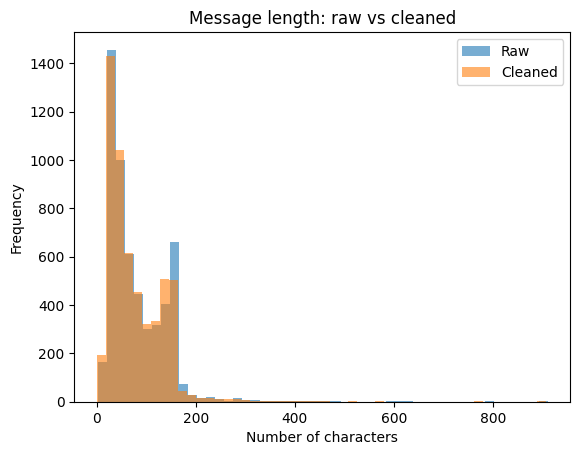

In [77]:
import matplotlib.pyplot as plt

# raw vs cleaned message length
dataset["raw_length"] = dataset["sms"].astype(str).str.len()
dataset["clean_length"] = dataset["sms_clean"].astype(str).str.len()

plt.figure()
plt.hist(dataset["raw_length"], bins=50, alpha=0.6, label="Raw")
plt.hist(dataset["clean_length"], bins=50, alpha=0.6, label="Cleaned")
plt.title("Message length: raw vs cleaned")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# **Model training** - Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression models (same hyperparameters for fair comparison)

# 1) CountVectorizer
logreg_count = LogisticRegression(max_iter=2000, random_state=42)
logreg_count.fit(X_count_train, y_train)

# 2) TF-IDF
logreg_tfidf = LogisticRegression(max_iter=2000, random_state=42)
logreg_tfidf.fit(X_tfidf_train, y_train)


LogisticRegression(max_iter=2000, random_state=42)

# **Model training** - Neural Network

In [68]:
from sklearn.neural_network import MLPClassifier

# Neural Network models (MLP) – training only

# 1) CountVectorizer
mlp_count = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation="relu",
    solver="adam",
    max_iter=30,
    random_state=42
)
mlp_count.fit(X_count_train.toarray(), y_train)

# 2) TF-IDF
mlp_tfidf = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation="relu",
    solver="adam",
    max_iter=30,
    random_state=42
)
mlp_tfidf.fit(X_tfidf_train.toarray(), y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128,), max_iter=30, random_state=42)

# **Model evaluation**

In [79]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

evaluation_results = []

def add_result(model, vectorizer, y_true, y_pred):
    evaluation_results.append({
        "Model": model,
        "Vectorizer": vectorizer,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    })

# Logistic Regression
add_result(
    "Logistic Regression",
    "Count",
    y_test,
    logreg_count.predict(X_count_test)
)

add_result(
    "Logistic Regression",
    "TF-IDF",
    y_test,
    logreg_tfidf.predict(X_tfidf_test)
)

# Neural Network (MLP)
add_result(
    "Neural Network (MLP)",
    "Count",
    y_test,
    mlp_count.predict(X_count_test.toarray())
)

add_result(
    "Neural Network (MLP)",
    "TF-IDF",
    y_test,
    mlp_tfidf.predict(X_tfidf_test.toarray())
)

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

,Model,Vectorizer,Accuracy,F1-score
0,Logistic Regression,Count,0.981166,0.924188
1,Logistic Regression,TF-IDF,0.957848,0.812749
2,Neural Network (MLP),Count,0.982960,0.931900
3,Neural Network (MLP),TF-IDF,0.983857,0.935714


# **Benchmarking** - F1 Score

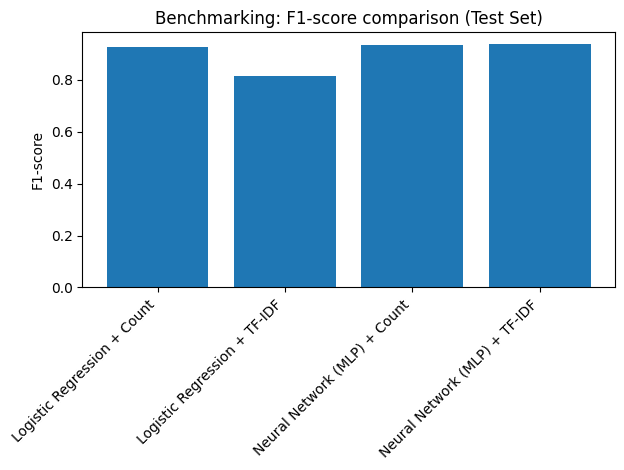

In [80]:
labels = evaluation_df["Model"] + " + " + evaluation_df["Vectorizer"]
f1_scores = evaluation_df["F1-score"]

plt.figure()
plt.bar(labels, f1_scores)
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1-score")
plt.title("Benchmarking: F1-score comparison (Test Set)")
plt.tight_layout()
plt.show()

# **Application demo (Spam detector)**

In [82]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1) Choose best configuration by F1-score
best_row = evaluation_df.sort_values("F1-score", ascending=False).iloc[0]
best_model_name = best_row["Model"]
best_vectorizer_name = best_row["Vectorizer"]

print("Best configuration based on test F1-score:")
print(best_row)

# 2) Build final train set = train + val (for the chosen vectorizer)
if best_vectorizer_name == "Count":
    X_trainval = X_count_trainval
    vectorizer_final = count_vectorizer
elif best_vectorizer_name == "TF-IDF":
    X_trainval = X_tfidf_trainval
    vectorizer_final = tfidf_vectorizer
else:
    raise ValueError("Unknown vectorizer name in evaluation_df")

y_trainval_final = y_trainval

# 3) Train final model on train+val
if "Logistic" in best_model_name:
    final_model = LogisticRegression(max_iter=2000, random_state=42)
    final_model.fit(X_trainval, y_trainval_final)
    needs_dense = False
else:
    final_model = MLPClassifier(
        hidden_layer_sizes=(128,),
        activation="relu",
        solver="adam",
        max_iter=30,
        random_state=42
    )
    final_model.fit(X_trainval.toarray(), y_trainval_final)
    needs_dense = True

# 4) End-to-end predict function (includes cleaning + vectorization)
def predict_sms(text: str):
    cleaned = clean_text(str(text))
    X_vec = vectorizer_final.transform([cleaned])
    if needs_dense:
        pred = final_model.predict(X_vec.toarray())[0]
        prob = final_model.predict_proba(X_vec.toarray())[0]
    else:
        pred = final_model.predict(X_vec)[0]
        prob = final_model.predict_proba(X_vec)[0]

    label_str = "SPAM" if pred == 1 else "NON-SPAM"
    confidence = float(np.max(prob))
    return cleaned, label_str, confidence

# 5) Simple UI
txt = widgets.Textarea(
    value="Free entry in 2 a wkly comp to win FA Cup final tkts!",
    description="SMS:",
    layout=widgets.Layout(width="100%", height="120px")
)
btn = widgets.Button(description="Predict", button_style="primary")
out = widgets.Output()

def on_click(_):
    with out:
        clear_output()
        cleaned, label_str, conf = predict_sms(txt.value)
        print("Cleaned text:")
        print(cleaned)
        print("\nPrediction:")
        print(f"{label_str}  (confidence: {conf:.3f})")

btn.on_click(on_click)

display(txt, btn, out)

Best configuration based on test F1-score:
Model         Neural Network (MLP)
Vectorizer                  TF-IDF
Accuracy                  0.983857
F1-score                  0.935714
Name: 3, dtype: object


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Textarea(value='Free entry in 2 a wkly comp to win FA Cup final tkts!', description='SMS:', layout=Layout(heig…

Button(button_style='primary', description='Predict', style=ButtonStyle())

Output()

## Conclusion

In this project, I implemented an end-to-end NLP pipeline for SMS spam detection.
The pipeline includes text cleaning, tokenization, vectorization using CountVectorizer and TF-IDF,
and classification using Logistic Regression and a simple Neural Network (MLP).

The models were evaluated on a held-out test set, and their performance was compared using accuracy
and F1-score. Since spam detection is an imbalanced classification problem, the F1-score proved to be
a more informative metric. The results show that TF-IDF generally performs slightly better than
CountVectorizer, while the differences between models are relatively small.

One limitation of this project is that only classical models were used.
In future work, more advanced architectures such as CNNs, RNNs, or Transformer-based models
could be explored, as well as more sophisticated preprocessing techniques.
